In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Language Translation with `nn.Transformer` and torchtext
========================================================

This tutorial shows:

:   -   How to train a translation model from scratch using Transformer.
    -   Use torchtext library to access
        [Multi30k](http://www.statmt.org/wmt16/multimodal-task.html#task1)
        dataset to train a German to English translation model.


Data Sourcing and Processing
============================

[torchtext library](https://pytorch.org/text/stable/) has utilities for
creating datasets that can be easily iterated through for the purposes
of creating a language translation model. In this example, we show how
to use torchtext\'s inbuilt datasets, tokenize a raw text sentence,
build vocabulary, and numericalize tokens into tensor. We will use
[Multi30k dataset from torchtext
library](https://pytorch.org/text/stable/datasets.html#multi30k) that
yields a pair of source-target raw sentences.

To access torchtext datasets, please install torchdata following
instructions at <https://github.com/pytorch/data>.


In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00


In [83]:
import os

from google.colab import drive
drive.mount('/content/drive')
# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

# the base Google Drive directory
root_dir = "/content/gdrive/MyDrive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/NLP_A3/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Mounted at /content/drive
Mounted at /content/gdrive

Your working directory was changed to /content/gdrive/MyDrive/Colab Notebooks/NLP_A3/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [84]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List
import datasets

dataset_train_wmt16 = datasets.load_dataset("wmt16","de-en", split="train[:100000]")
dataset_val_wmt16 = datasets.load_dataset("wmt16","de-en", split="validation")
dataset_test_wmt16 = datasets.load_dataset("wmt16","de-en", split="test")

# # We need to modify the URLs for the dataset since the links to the original dataset are broken
# # Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
# multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
# multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

Create source and target language tokenizer. Make sure to install the
dependencies.

``` {.sourceCode .python}
pip install -U torchdata
pip install -U spacy
python -m spacy download en_core_web_sm
python -m spacy download de_core_news_sm
```


In [3]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 92.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 84.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
!pip install portalocker

In [85]:
def wmt16_to_multi30k_format(dataset):
    """
    Converts the WMT16 dataset format to a simple iterable of (source, target) tuples.

    Args:
    - dataset: A loaded dataset from Hugging Face's `datasets` library, expected to be WMT16.

    Returns:
    - An iterable of (source_text, target_text) tuples.
    """
    for example in dataset:
        source_text = example['translation']['de']
        target_text = example['translation']['en']
        yield (source_text, target_text)

In [86]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = list(wmt16_to_multi30k_format(dataset_train_wmt16)) # Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Seq2Seq Network using Transformer
=================================

Transformer is a Seq2Seq model introduced in ["Attention is all you
need"](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
paper for solving machine translation tasks. Below, we will create a
Seq2Seq network that uses Transformer. The network consists of three
parts. First part is the embedding layer. This layer converts tensor of
input indices into corresponding tensor of input embeddings. These
embedding are further augmented with positional encodings to provide
position information of input tokens to the model. The second part is
the actual
[Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)
model. Finally, the output of the Transformer model is passed through
linear layer that gives unnormalized probabilities for each token in the
target language.


In [87]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

During training, we need a subsequent word mask that will prevent the
model from looking into the future words when making predictions. We
will also need masks to hide source and target padding tokens. Below,
let\'s define a function that will take care of both.


In [88]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Let\'s now define the parameters of our model and instantiate the same.
Below, we also define our loss function which is the cross-entropy loss
and the optimizer used for training.


In [89]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9, weight_decay=1e-5)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Collation
=========

As seen in the `Data Sourcing and Processing` section, our data iterator
yields a pair of raw strings. We need to convert these string pairs into
the batched tensors that can be processed by our `Seq2Seq` network
defined previously. Below we define our collate function that converts a
batch of raw strings into batch tensors that can be fed directly into
our model.


In [90]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Let\'s define training and evaluation loop that will be called for each
epoch.


In [91]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = list(wmt16_to_multi30k_format(dataset_train_wmt16)) # Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = list(wmt16_to_multi30k_format(dataset_val_wmt16)) # Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))


def test(model):
    model.eval()
    losses = 0

    test_iter = list(wmt16_to_multi30k_format(dataset_test_wmt16)) # Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    test_dataloader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in test_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(test_dataloader))

Now we have all the ingredients to train our model. Let\'s do it!


In [92]:
from timeit import default_timer as timer
path = root_dir + project_folder + 'best_model.pth'
NUM_EPOCHS = 15
train_loss_collector = []
val_loss_collector = []
patience = 2
best_val_loss = float('inf')
patience_counter = 0
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    train_loss_collector.append(train_loss)
    end_time = timer()
    val_loss = evaluate(transformer)
    val_loss_collector.append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset counter
        torch.save(transformer.state_dict(), path)
    else:
        patience_counter += 1
        if patience_counter > patience:
            print("Stopping early due to increasing validation loss.")
            break

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1, Train loss: 5.684, Val loss: 6.402, Epoch time = 173.858s
Epoch: 2, Train loss: 4.539, Val loss: 5.955, Epoch time = 173.845s
Epoch: 3, Train loss: 4.066, Val loss: 5.666, Epoch time = 174.416s
Epoch: 4, Train loss: 3.709, Val loss: 5.451, Epoch time = 175.285s
Epoch: 5, Train loss: 3.417, Val loss: 5.277, Epoch time = 174.498s
Epoch: 6, Train loss: 3.182, Val loss: 5.139, Epoch time = 173.928s
Epoch: 7, Train loss: 2.988, Val loss: 5.017, Epoch time = 173.697s
Epoch: 8, Train loss: 2.825, Val loss: 4.916, Epoch time = 174.037s
Epoch: 9, Train loss: 2.688, Val loss: 4.864, Epoch time = 173.901s
Epoch: 10, Train loss: 2.570, Val loss: 4.832, Epoch time = 174.119s
Epoch: 11, Train loss: 2.466, Val loss: 4.830, Epoch time = 174.069s
Epoch: 12, Train loss: 2.375, Val loss: 4.807, Epoch time = 173.814s
Epoch: 13, Train loss: 2.293, Val loss: 4.793, Epoch time = 174.059s
Epoch: 14, Train loss: 2.215, Val loss: 4.783, Epoch time = 174.070s
Epoch: 15, Train loss: 2.146, Val loss: 4.7

In [96]:
# Compute test loss
test_loss = test(transformer)
print(f"Test loss: {test_loss:.3f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Test loss: 4.702


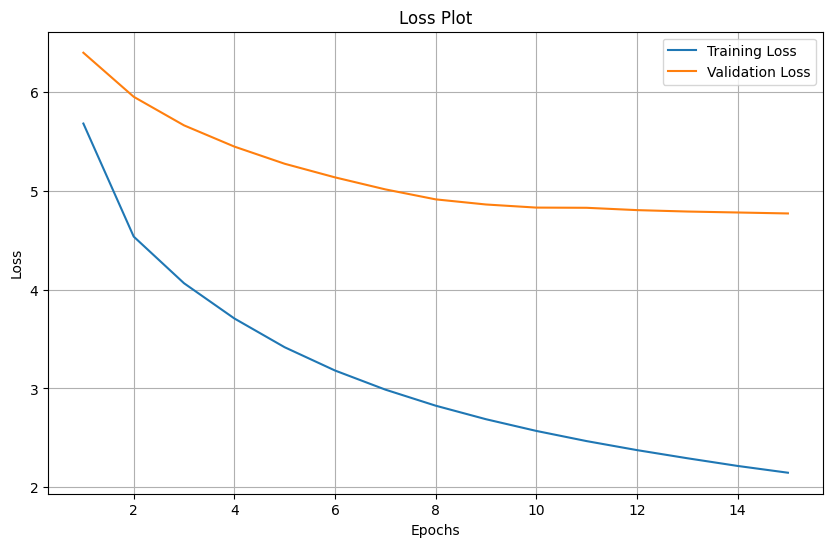

In [97]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    epochs = len(train_losses)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the loss curves
plot_losses(train_loss_collector, val_loss_collector)

In [95]:
path = root_dir + project_folder + '2A_final_model.pth'
torch.save(transformer.state_dict(), path)

In [108]:
model_loaded = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

model_loaded.load_state_dict(torch.load(path))
model_loaded = model_loaded.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [98]:
# model = transformer
# model_state = {
#     'state_dict': model.state_dict(),
#     'optimizer': optimizer.state_dict(),
# }

# torch.save(model_state, '2A_model_checkpoint.pth')

In [99]:
# model_state = torch.load('2A_model_checkpoint.pth')

# model.load_state_dict(model_state['state_dict'])
# optimizer.load_state_dict(model_state['optimizer'])

# transformer = model


In [100]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))

 A group of people is still a minimum level of transport . 


In [101]:
!pip install sacrebleu

In [102]:
from sacrebleu.metrics import BLEU
from tqdm import tqdm

def calculate_test_bleu_scores(dataset, model):
    references = []
    hypotheses = []

    bleu = BLEU()

    for example in tqdm(dataset, desc="Translating"):
        src_sentence = example['translation']['de']
        ref_translation = example['translation']['en']

        hyp_translation = translate(model, src_sentence)

        references.append([ref_translation])  # list of possible references is expected by sacrebleu
        hypotheses.append(hyp_translation)

    # Calculate BLEU scores
    bleu_scores = bleu.corpus_score(hypotheses, references)

    # Extract and print BLEU scores for 1-grams to 4-grams
    print(f"BLEU-1: {bleu_scores.precisions[0]}")
    print(f"BLEU-2: {bleu_scores.precisions[1]}")
    print(f"BLEU-3: {bleu_scores.precisions[2]}")
    print(f"BLEU-4: {bleu_scores.score}")

    return bleu_scores

# Calculating BLEU metrics for the validation corpus
bleu_scores = calculate_test_bleu_scores(dataset_val_wmt16, transformer)

# Calculating BLEU metrics for the test corpus
bleu_scores = calculate_test_bleu_scores(dataset_test_wmt16, transformer)


Translating: 100%|██████████| 2169/2169 [03:51<00:00,  9.35it/s]


BLEU-1: 100.0
BLEU-2: 71.42857142857143
BLEU-3: 30.76923076923077
BLEU-4: 36.78763249927777


Translating: 100%|██████████| 2999/2999 [05:29<00:00,  9.11it/s]


BLEU-1: 100.0
BLEU-2: 25.0
BLEU-3: 7.142857142857143
BLEU-4: 16.51582159006904


In [103]:
!pip install nltk

In [104]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [105]:
from nltk.translate.meteor_score import single_meteor_score
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Ensure that NLTK's tokenizers are downloaded
nltk.download('punkt')

def calculate_meteor_score(dataset, model):
    total_score = 0
    num_examples = 0

    for example in tqdm(dataset, desc="Evaluating"):
        src_sentence = example['translation']['de']
        reference = example['translation']['en']

        hypothesis = translate(model, src_sentence)

        reference_tokens = word_tokenize(reference, language='english')
        hypothesis_tokens = word_tokenize(hypothesis, language='english')

        score = single_meteor_score(reference_tokens, hypothesis_tokens)
        total_score += score
        num_examples += 1

    average_score = total_score / num_examples
    return average_score

# Calculate METEOR score for the validation corpus
meteor_score = calculate_meteor_score(dataset_val_wmt16, transformer)
print(f"Average METEOR Score for validation data: {meteor_score:.4f}")

# Calculate METEOR score for the test corpus
meteor_score = calculate_meteor_score(dataset_test_wmt16, transformer)
print(f"Average METEOR Score for test data: {meteor_score:.4f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Evaluating: 100%|██████████| 2169/2169 [03:58<00:00,  9.11it/s]


Average METEOR Score for validation data: 0.3043


Evaluating: 100%|██████████| 2999/2999 [05:36<00:00,  8.91it/s]

Average METEOR Score for test data: 0.3153


In [106]:
!pip install bert_score

In [107]:
from bert_score import score
from tqdm import tqdm
import torch

def calculate_bertscore(dataset, model, device='cuda'):
    # Lists to hold all reference translations and model hypotheses
    references = []
    hypotheses = []

    # Ensure the model is on the correct device
    model.to(device)

    for example in tqdm(dataset, desc="Generating Translations"):
        src_sentence = example['translation']['de']
        reference = example['translation']['en']

        # Generate model's translation
        hypothesis = translate(model, src_sentence)

        references.append(reference)
        hypotheses.append(hypothesis)

    # Compute BERTScore
    P, R, F1 = score(hypotheses, references, lang="en", verbose=True)

    # Calculate average scores
    avg_precision = torch.mean(P).item()
    avg_recall = torch.mean(R).item()
    avg_f1 = torch.mean(F1).item()

    return avg_precision, avg_recall, avg_f1

# Calculate BERTscore on validation corpus
print("BERTscore for validation data: ")
avg_precision, avg_recall, avg_f1 = calculate_bertscore(dataset_val_wmt16, transformer)
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1: {avg_f1:.4f}")

# Calculate BERTscore on test corpus
print("BERTscore for test data: ")
avg_precision, avg_recall, avg_f1 = calculate_bertscore(dataset_test_wmt16, transformer)
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1: {avg_f1:.4f}")


BERTscore for validation data: 


Generating Translations: 100%|██████████| 2169/2169 [03:55<00:00,  9.19it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/68 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/34 [00:00<?, ?it/s]

done in 7.60 seconds, 285.45 sentences/sec
Average Precision: 0.8538
Average Recall: 0.8632
Average F1: 0.8584
BERTscore for test data: 


Generating Translations: 100%|██████████| 2999/2999 [05:27<00:00,  9.16it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/94 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/47 [00:00<?, ?it/s]

done in 10.15 seconds, 295.47 sentences/sec
Average Precision: 0.8536
Average Recall: 0.8607
Average F1: 0.8570


In [109]:
print(translate(model_loaded, "Eine Gruppe von Menschen steht vor einem Iglu ."))

 A group of people is still a minimum level of transport . 


References
==========

1.  Attention is all you need paper.
    <https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf>
2.  The annotated transformer.
    <https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding>
